# EDA Exploratory Data Analysis: Penguin Species Classification

Quick exploration to understand what we're working with and identify issues before preprocessing.

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [142]:
df = pd.read_csv('data.csv')
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


## Dataset Structure

Shape: 344 rows × 17 columns

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studyName            344 non-null    object 
 1   Sample Number        344 non-null    int64  
 2   Species              344 non-null    object 
 3   Region               344 non-null    object 
 4   Island               344 non-null    object 
 5   Stage                344 non-null    object 
 6   Individual ID        344 non-null    object 
 7   Clutch Completion    344 non-null    object 
 8   Date Egg             344 non-null    object 
 9   Culmen Length (mm)   342 non-null    float64
 10  Culmen Depth (mm)    342 non-null    float64
 11  Flipper Length (mm)  342 non-null    float64
 12  Body Mass (g)        342 non-null    float64
 13  Sex                  334 non-null    object 
 14  Delta 15 N (o/oo)    330 non-null    float64
 15  Delta 13 C (o/oo)    331 non-null    flo

## Data Types Classification

Let's see what types of features we're working with.
from df.info() we can see a lot of object types (strings) that need transformation. we also have missing values everywhere - culmen length onwards are the morphological measurements. 

In [144]:
# Classify features by data type
categorical_features = []
numerical_features = []

for col in df.columns:
    if df[col].dtype == 'object':
        unique_vals = df[col].unique()
        display_vals = unique_vals[:10] if len(unique_vals) > 10 else unique_vals
        print(f"Feature '{col}' has {len(unique_vals)} Unique Values: {display_vals}{'...' if len(unique_vals) > 10 else ''}\n")
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

Feature 'studyName' has 3 Unique Values: ['PAL0708' 'PAL0809' 'PAL0910']

Feature 'Species' has 3 Unique Values: ['Adelie Penguin (Pygoscelis adeliae)'
 'Chinstrap penguin (Pygoscelis antarctica)'
 'Gentoo penguin (Pygoscelis papua)']

Feature 'Region' has 1 Unique Values: ['Anvers']

Feature 'Island' has 3 Unique Values: ['Torgersen' 'Biscoe' 'Dream']

Feature 'Stage' has 1 Unique Values: ['Adult, 1 Egg Stage']

Feature 'Individual ID' has 190 Unique Values: ['N1A1' 'N1A2' 'N2A1' 'N2A2' 'N3A1' 'N3A2' 'N4A1' 'N4A2' 'N5A1' 'N5A2']...

Feature 'Clutch Completion' has 2 Unique Values: ['Yes' 'No']

Feature 'Date Egg' has 50 Unique Values: ['11/11/07' '11/16/07' '11/15/07' '11/9/07' '11/12/07' '11/10/07'
 '11/13/07' '11/19/07' '11/6/08' '11/9/08']...

Feature 'Sex' has 4 Unique Values: ['MALE' 'FEMALE' nan '.']

Feature 'Comments' has 8 Unique Values: ['Not enough blood for isotopes.' nan 'Adult not sampled.'
 'Nest never observed with full clutch.' 'No blood sample obtained.'
 'No blood s

from the categorical breakdown we can see:
- sex has 4 unique values including '.' which is a data entry error and nan which is just absence, should be treated as missing
- region and stage have only 1 unique value each - useless for prediction, just noise
- island has 3 values - might be useful if species are geographically separated
- comments explains why data is missing - valuable for imputation strategy
- individual ID has 190 unique values but we have 344 samples - turns out IDs are reused across studies for different birds (see investigation below)

In [145]:
# Create simplified species names for plotting
df['Species_Short'] = df['Species'].map({
    'Adelie Penguin (Pygoscelis adeliae)': 'Adelie',
    'Gentoo penguin (Pygoscelis papua)': 'Gentoo',
    'Chinstrap penguin (Pygoscelis antarctica)': 'Chinstrap'
})

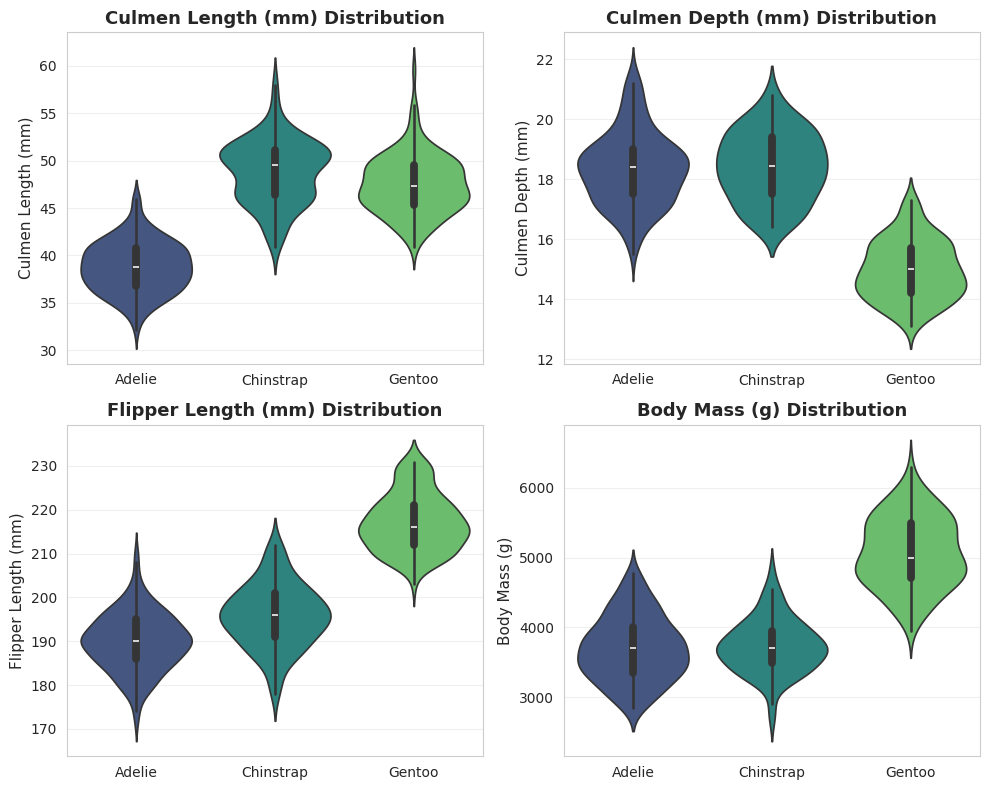

In [146]:
morph_features = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']

# Violin plots showing full distributions
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for idx, feature in enumerate(morph_features):
    sns.violinplot(data=df, x='Species_Short', y=feature, palette='viridis', inner='box', ax=axes[idx])
    axes[idx].set_title(f'{feature} Distribution', fontsize=13, fontweight='bold')
    axes[idx].set_ylabel(feature, fontsize=11)
    axes[idx].set_xlabel('')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

looking at both the mean comparison and full distributions:

**why these are the main predictors:**
- **flipper length**: gentoo ~215mm, adelie ~190mm, chinstrap ~195mm - means are clearly separated
- **body mass**: gentoo ~5000g vs adelie/chinstrap ~3700-3800g - gentoo is way heavier
- **culmen depth**: adelie and chinstrap ~18.5mm, gentoo ~15mm (shallowest) gentoo is diferent
- **culmen length**: single features that we can make clear distingtion between adelie and chinstrap

these measurements vary between species especially for gentoo - that's biological signal we can use.

**also we can conclude:**
- **gentoo is distinct** - clearly separated in flipper length, body mass and culmen depth (as we will see later gentoo is only on Biscoe island and the difference between the only one other species on that island Adelie is masiive so we will not have any problem clasifing this species)
- **adelie and chinstrap heavily overlap** - body mass and culmen depth distributions almost identical, chinstrap just has fewer samples and they are only on dream island so this will be the main problem but still we have clear distinguish on dulmen length
- **data is a lil skewed** - violin shapes aren't fully symmetric (i suppose thats because of the gender (thats because of the gender i tested it))
- **outliers present** - see the points sticking out in body mass and flipper length (i will keep them cause they are real biological data so if the dataset will be even bigger this will normalize)

so only culmen lenght  perfectly separate adelie from chinstrap. gentoo is easy, adelie vs chinstrap is the challenge.

**Why Morphological Features Matter**

Checking if these measurements actually differ between species - if they don't vary much, they're useless for classification.

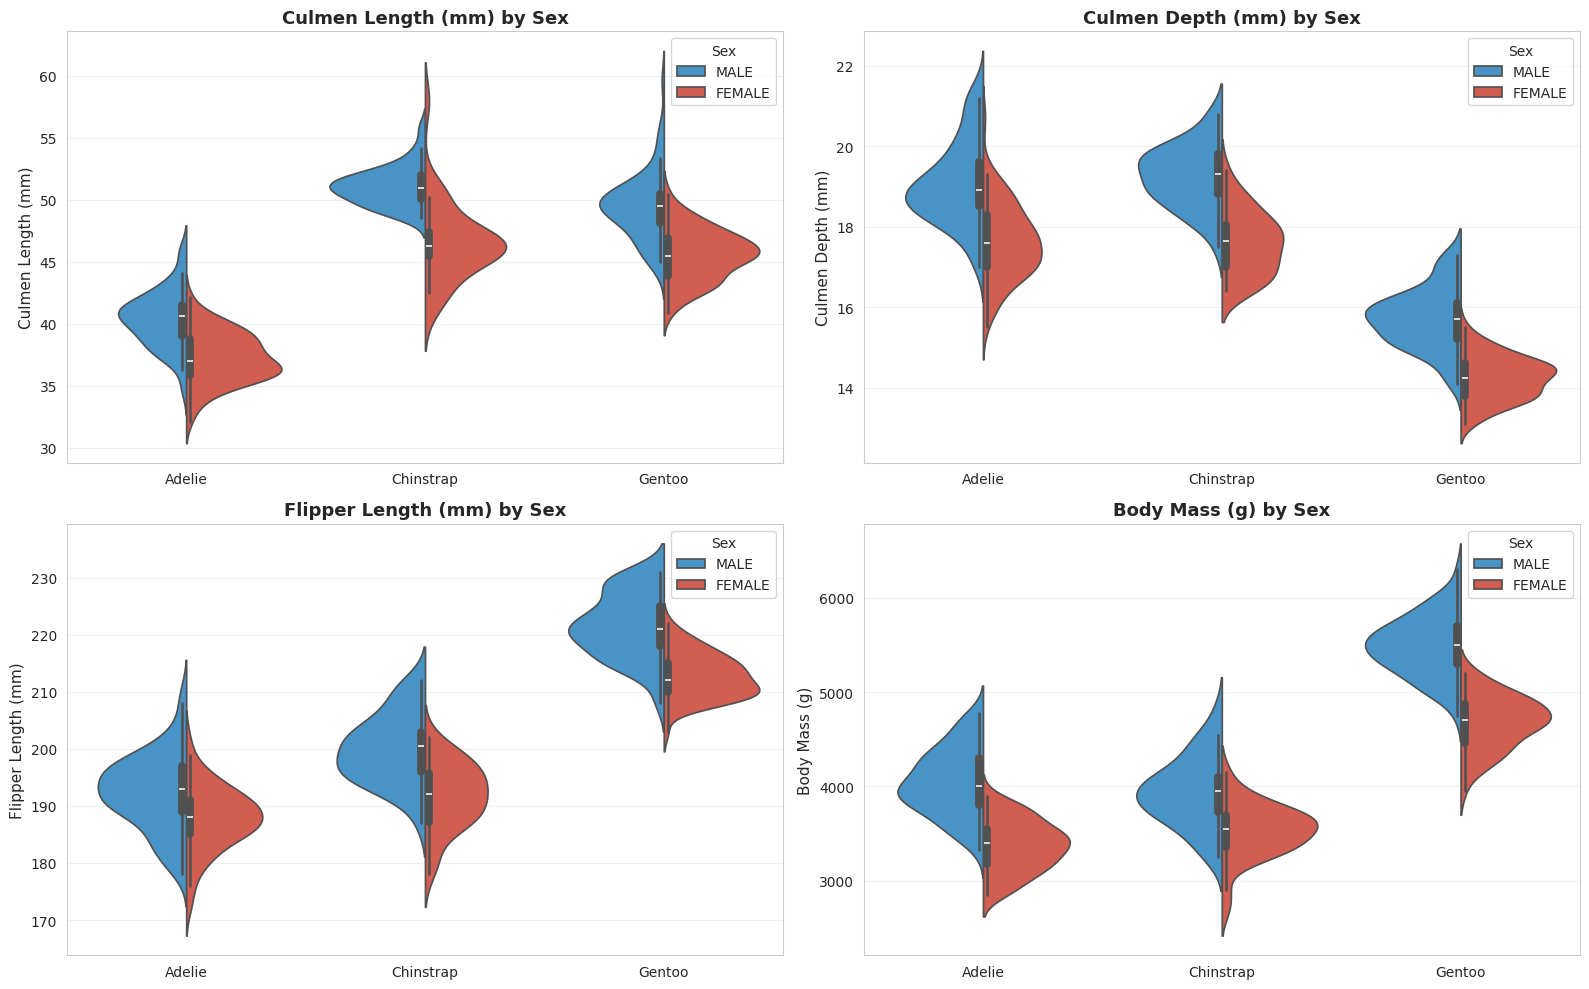

In [147]:
# Sex differences in morphological features - does gender explain the skewness?
df_sex_clean = df[df['Sex'].isin(['MALE', 'FEMALE'])]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(morph_features):
    sns.violinplot(data=df_sex_clean, x='Species_Short', y=feature, hue='Sex', 
                   palette={'MALE': '#3498db', 'FEMALE': '#e74c3c'}, 
                   split=True, inner='box', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Sex', fontsize=13, fontweight='bold')
    axes[idx].set_ylabel(feature, fontsize=11)
    axes[idx].set_xlabel('')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].legend(title='Sex', loc='best')

plt.tight_layout()
plt.show()

so here we ensured that the data about this main morphological data is skewed due to gender differences

**Isotope Features Analysis**

isotopes (Delta 15 N and Delta 13 C) reflect diet and trophic level. different species might have different feeding behaviors.

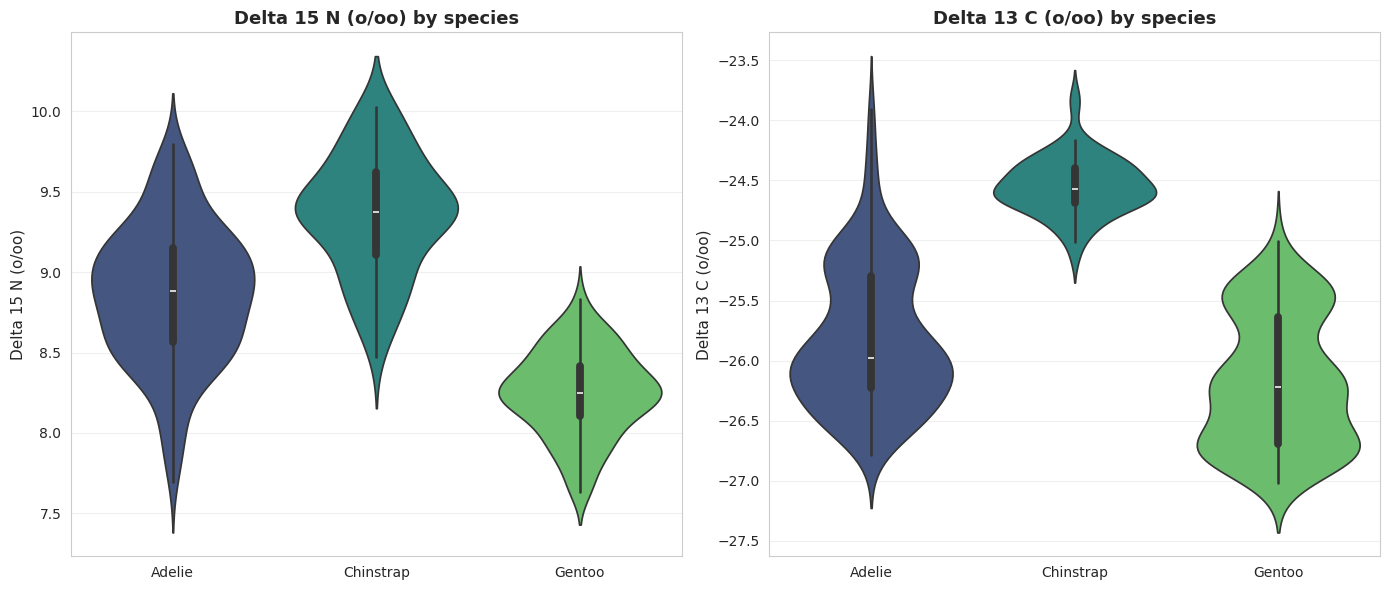

In [148]:
isotope_features = ['Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']

# violin plots by species
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, feature in enumerate(isotope_features):
    sns.violinplot(data=df, x='Species_Short', y=feature, palette='viridis', inner='box', ax=axes[idx])
    axes[idx].set_title(f'{feature} by species', fontsize=13, fontweight='bold')
    axes[idx].set_ylabel(feature, fontsize=11)
    axes[idx].set_xlabel('')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

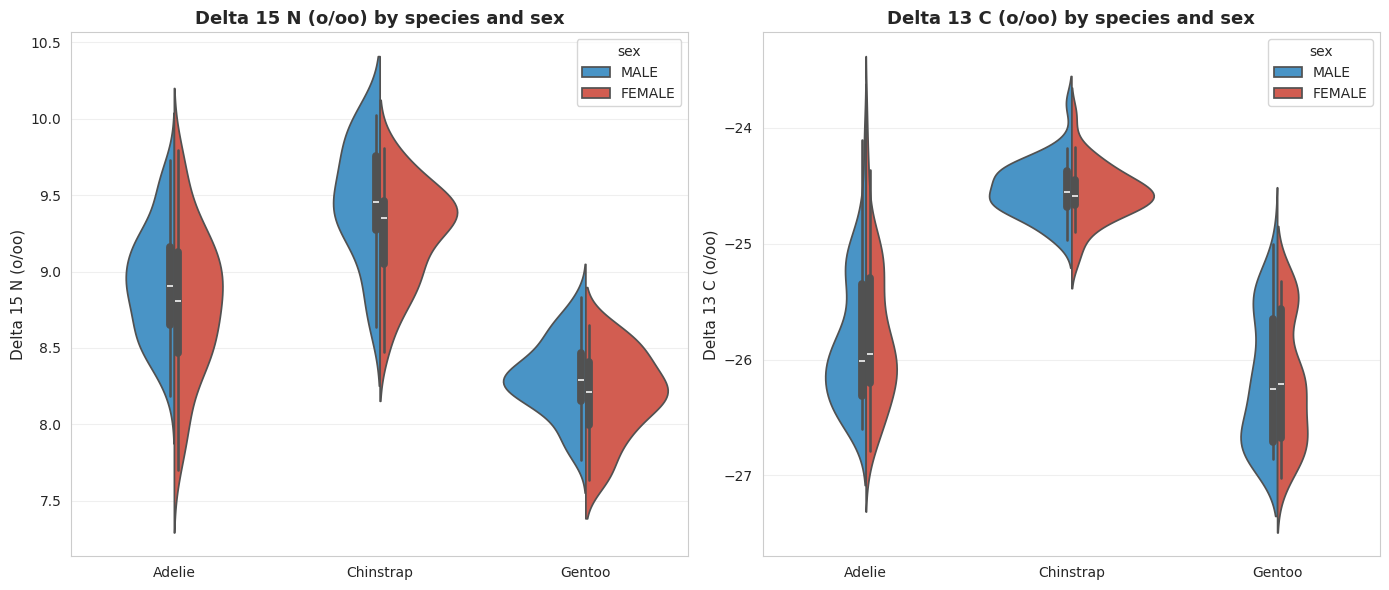

In [149]:
# isotope features by species and sex - split violin plots
df_sex_clean = df[df['Sex'].isin(['MALE', 'FEMALE'])]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, feature in enumerate(isotope_features):
    sns.violinplot(data=df_sex_clean, x='Species_Short', y=feature, hue='Sex',
                   palette={'MALE': '#3498db', 'FEMALE': '#e74c3c'},
                   split=True, inner='box', ax=axes[idx])
    axes[idx].set_title(f'{feature} by species and sex', fontsize=13, fontweight='bold')
    axes[idx].set_ylabel(feature, fontsize=11)
    axes[idx].set_xlabel('')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].legend(title='sex', loc='best')

plt.tight_layout()
plt.show()

**isotope analysis:**

both isotope features show heavy overlap between species. sex doesn't create clear separation within species either, but this features are some of only features that lets us distinquish clearly between chinstrap and rest of the species.

isotopes might provide marginal value as secondary features but won't be primary predictors. morphological features are far stronger.

**Individual ID Investigation**

344 samples but only 190 unique individual IDs - are these repeated measurements?

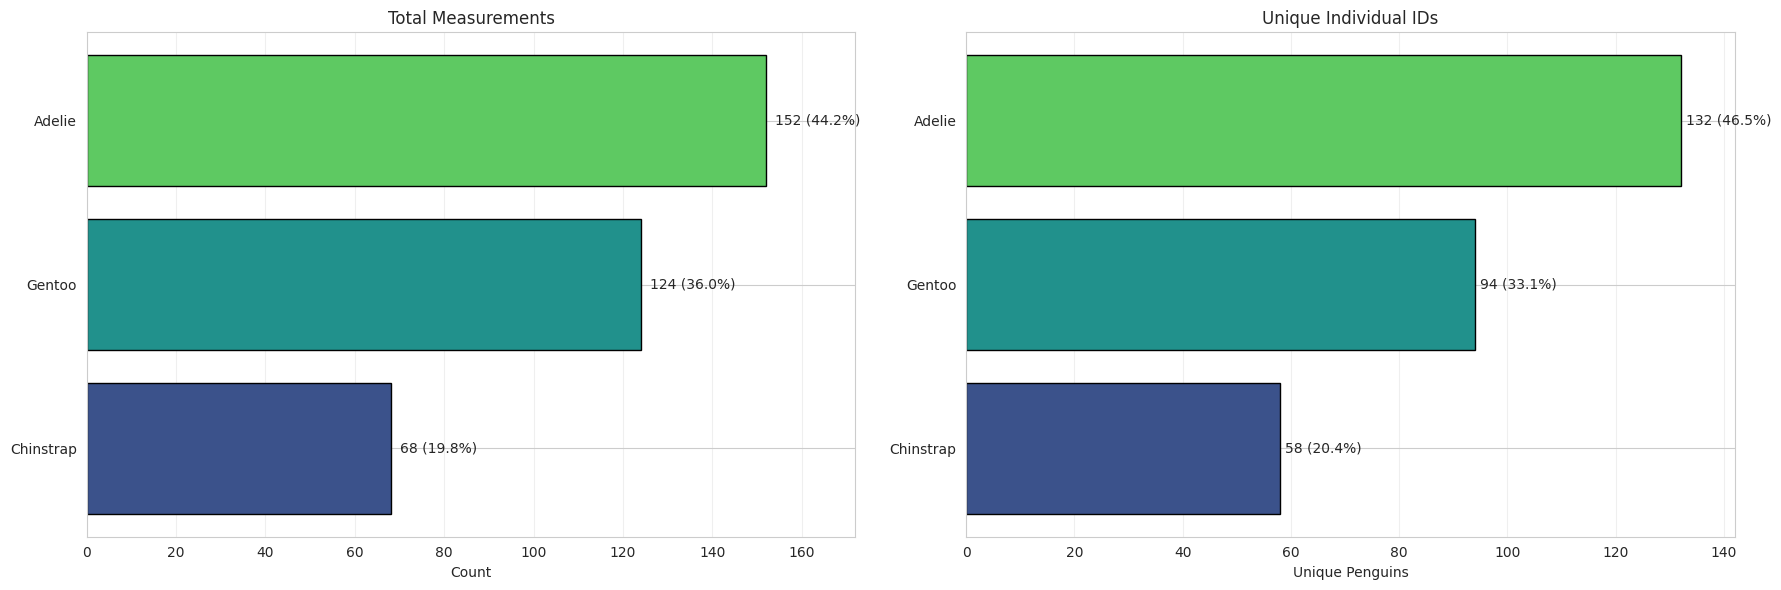

In [150]:
# Species distribution - total measurements vs unique penguins
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

species_counts = df['Species_Short'].value_counts().sort_values(ascending=True)
colors = sns.color_palette('viridis', n_colors=len(species_counts))
bars1 = axes[0].barh(species_counts.index, species_counts.values, color=colors, edgecolor='black')

for i, (count, name) in enumerate(zip(species_counts.values, species_counts.index)):
    percentage = (count / len(df)) * 100
    axes[0].text(count + 2, i, f'{count} ({percentage:.1f}%)', va='center')

axes[0].set_xlabel('Count')
axes[0].set_title('Total Measurements')
axes[0].set_xlim(0, max(species_counts.values) + 20)
axes[0].grid(axis='x', alpha=0.3)

unique_penguins = df.groupby('Species_Short')['Individual ID'].nunique().sort_values(ascending=True)
bars2 = axes[1].barh(unique_penguins.index, unique_penguins.values, color=colors, edgecolor='black')

total_unique = unique_penguins.sum()
for i, (count, name) in enumerate(zip(unique_penguins.values, unique_penguins.index)):
    percentage = (count / total_unique) * 100
    axes[1].text(count + 1, i, f'{count} ({percentage:.1f}%)', va='center')

axes[1].set_xlabel('Unique Penguins')
axes[1].set_title('Unique Individual IDs')
axes[1].set_xlim(0, max(unique_penguins.values) + 10)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

we can clearly see that our dataset is highly imbalanced - we have more than twice the data for adelie compared to chinstrap. data augmentation is based and using SMOTEENN is a valuable choice for balancing during training.
and i had a hypotesis that maybe they just measured some penguens species more often then others but fortunately no and our penguins are fine xd


OMG WTF I WAS WRONG UNIQUE ID ARE JUST IDENTIFIER PER STUDY NAME, I ACCTUALLY DID NOT OBSERVE THIS INITIALLY JSADFHLISHFKHASDJFHAJSDGHLJ
I WILL LEFT THIS HERE AND BELOW MAKE AN ANALYSIS TAKING THIS INTO CONSIDERATION BECAUSE ALL 344 PENGUINS ARE UNIQE THATS JUST SOME NAMING CONVETIONS THERE, IF WE COMBINE INDIVIDUAL_ID WITH STUDY NAME WE RESULT IN 344 DIFFERENT PENGUINS 

In [151]:
# checking if IDs are reused across studies

print(f"total rows: {len(df)}")
print(f"unique individual IDs: {df['Individual ID'].nunique()}")
print(f"190 IDs but 344 rows?\n")

# look at some examples
print("N11A1:")
print(df[df['Individual ID'] == 'N11A1'][['Individual ID', 'Species_Short', 'studyName', 'Body Mass (g)']].to_string(index=False))

print("N13A2:")
print(df[df['Individual ID'] == 'N13A2'][['Individual ID', 'Species_Short', 'studyName', 'Body Mass (g)']].to_string(index=False))

print("N18A1:")
print(df[df['Individual ID'] == 'N18A1'][['Individual ID', 'Species_Short', 'studyName', 'Body Mass (g)']].to_string(index=False))

# count how many IDs have multiple species
id_species_count = df.groupby('Individual ID')['Species_Short'].nunique()
reused_ids = (id_species_count > 1).sum()

print(f"{reused_ids} IDs appear with different species labels")
print(f"they reused the same ID numbers across different study years for different birds")
print(f"so we actually have 344 unique penguins, not 190")

total rows: 344
unique individual IDs: 190
190 IDs but 344 rows?

N11A1:
Individual ID Species_Short studyName  Body Mass (g)
        N11A1        Adelie   PAL0708         3400.0
        N11A1        Gentoo   PAL0809         4200.0
N13A2:
Individual ID Species_Short studyName  Body Mass (g)
        N13A2        Adelie   PAL0708         3800.0
        N13A2        Gentoo   PAL0809         5300.0
        N13A2        Gentoo   PAL0910         5300.0
N18A1:
Individual ID Species_Short studyName  Body Mass (g)
        N18A1        Adelie   PAL0708         3150.0
        N18A1        Gentoo   PAL0809         4200.0
        N18A1        Gentoo   PAL0910         4750.0
94 IDs appear with different species labels
they reused the same ID numbers across different study years for different birds
so we actually have 344 unique penguins, not 190


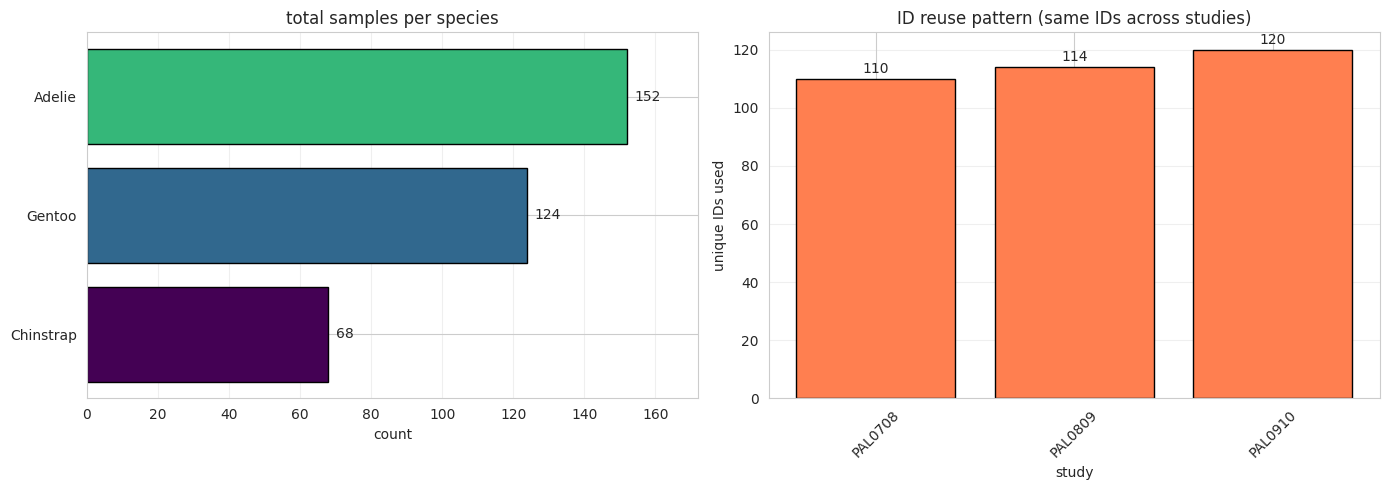


total unique penguins: 344 they all are different xdddd i spend so much time i wanna cry


In [152]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

species_counts = df['Species_Short'].value_counts().sort_values(ascending=True)
axes[0].barh(species_counts.index, species_counts.values, color=['#440154', '#31688e', '#35b779'], edgecolor='black')
for i, (count, name) in enumerate(zip(species_counts.values, species_counts.index)):
    axes[0].text(count + 2, i, f'{count}', va='center')
axes[0].set_xlabel('count')
axes[0].set_title('total samples per species')
axes[0].set_xlim(0, max(species_counts.values) + 20)
axes[0].grid(axis='x', alpha=0.3)

study_ids = df.groupby('studyName')['Individual ID'].nunique()
axes[1].bar(study_ids.index, study_ids.values, color='coral', edgecolor='black')
for i, (study, count) in enumerate(study_ids.items()):
    axes[1].text(i, count + 2, f'{count}', ha='center')
axes[1].set_xlabel('study')
axes[1].set_ylabel('unique IDs used')
axes[1].set_title('ID reuse pattern (same IDs across studies)')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\ntotal unique penguins: {len(df)} they all are different xdddd i spend so much time i wanna cry")

yeap we clearly have 344 different penguins and i just made a mistaken assumption

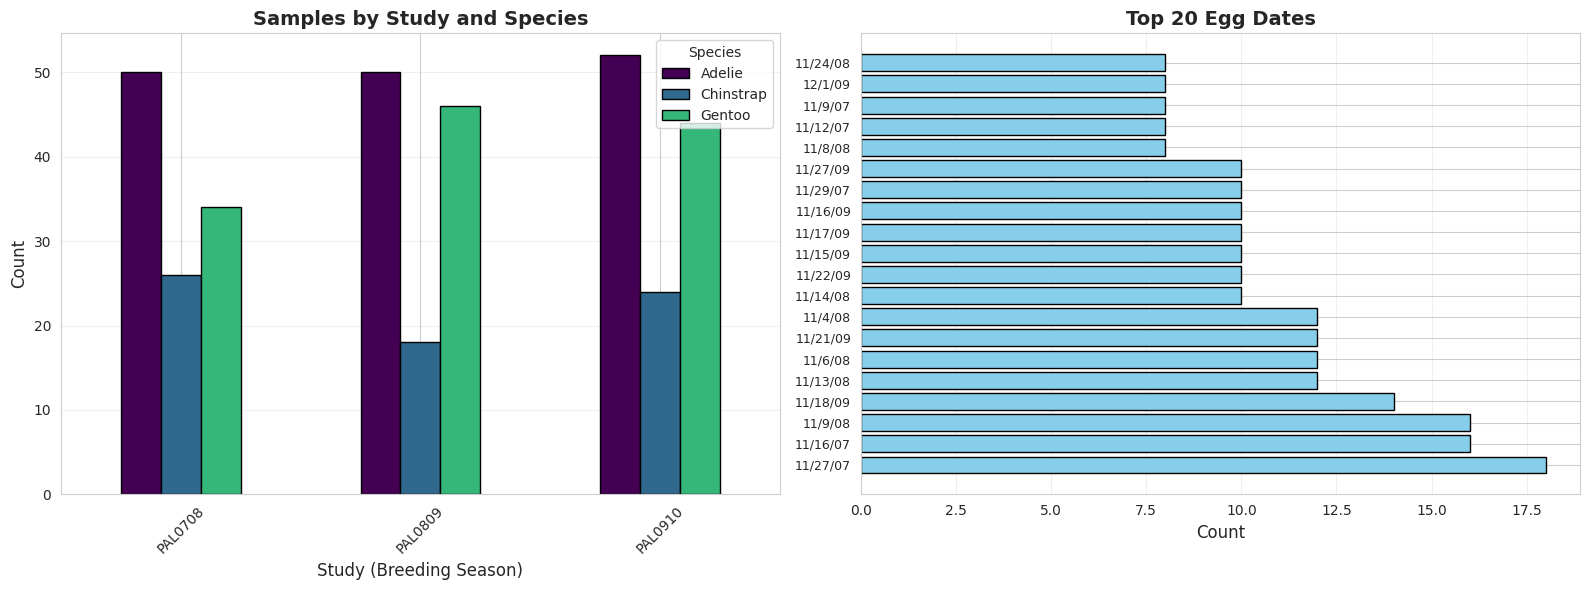

In [153]:
# Check Date Egg distribution and studyName relationship
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Samples per study
study_counts = df.groupby(['studyName', 'Species_Short']).size().unstack(fill_value=0)
study_counts.plot(kind='bar', ax=axes[0], color=['#440154', '#31688e', '#35b779'], edgecolor='black')
axes[0].set_title('Samples by Study and Species', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Study (Breeding Season)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(title='Species')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Date distribution
date_counts = df['Date Egg'].value_counts().head(20)
axes[1].barh(range(len(date_counts)), date_counts.values, color='skyblue', edgecolor='black')
axes[1].set_yticks(range(len(date_counts)))
axes[1].set_yticklabels(date_counts.index, fontsize=9)
axes[1].set_xlabel('Count', fontsize=12)
axes[1].set_title('Top 20 Egg Dates', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

**studyName shows temporal patterns:**
- PAL0708: mostly adelie
- PAL0809: more gentoo appears
- PAL0910: balanced mix of all three

this could capture year-specific effects or just reflects which islands/species they focused on that season. probably not super predictive for species classification since species don't change year to year - more likely just sampling bias.

**date egg:** 50 unique dates spread across breeding seasons. dates cluster in november for most studies. not useful for species prediction - we're trying to classify species, not predict when eggs were laid.

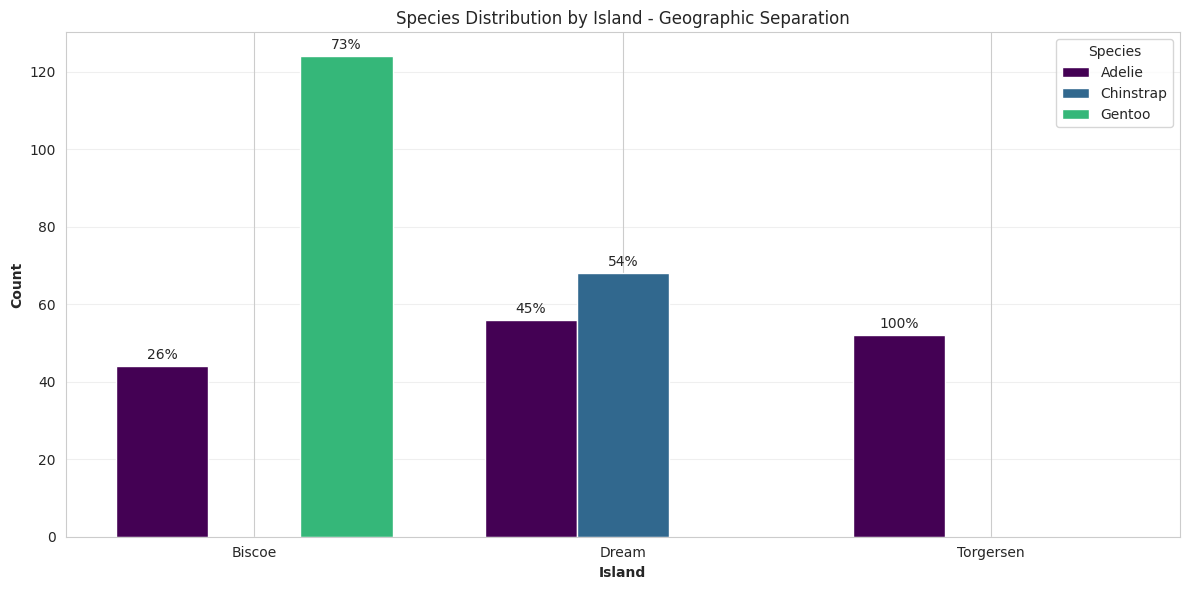

In [154]:
# Island geographic separation visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Create matrix showing which species are on which island
island_species_matrix = pd.crosstab(df['Island'], df['Species_Short'])
island_species_pct = pd.crosstab(df['Island'], df['Species_Short'], normalize='index') * 100

# Plot grouped bars
x = np.arange(len(island_species_matrix.index))
width = 0.25
colors = ['#440154', '#31688e', '#35b779']

for i, (species, color) in enumerate(zip(island_species_matrix.columns, colors)):
    bars = ax.bar(x + i*width, island_species_matrix[species], width, label=species, color=color)
    # Add percentage labels on bars
    for j, (bar, pct) in enumerate(zip(bars, island_species_pct[species])):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{int(pct)}%', ha='center', va='bottom')

ax.set_xlabel('Island',fontweight='bold')
ax.set_ylabel('Count',fontweight='bold')
ax.set_title('Species Distribution by Island - Geographic Separation')
ax.set_xticks(x + width)
ax.set_xticklabels(island_species_matrix.index)
ax.legend(title='Species', loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

holy shit island is actually a super strong predictor:

- **torgersen**: 100% adelie, zero gentoo, zero chinstrap
- **biscoe**: adelie + gentoo mix, absolutely NO chinstrap and this too species are highly different
- **dream**: adelie + chinstrap mix, NO gentoo at all, this is the only island that could give us some headache

so if you see a penguin on torgersen → it's automatically adelie. on dream → can't be gentoo. on biscoe → can't be chinstrap.

this is geographic separation - different species evolved to occupy different islands. island basically acts as a hard constraint that eliminates some species possibilities immediately. that's why target imputation will work great here - it directly encodes "being on dream island makes you X% likely to be chinstrap".

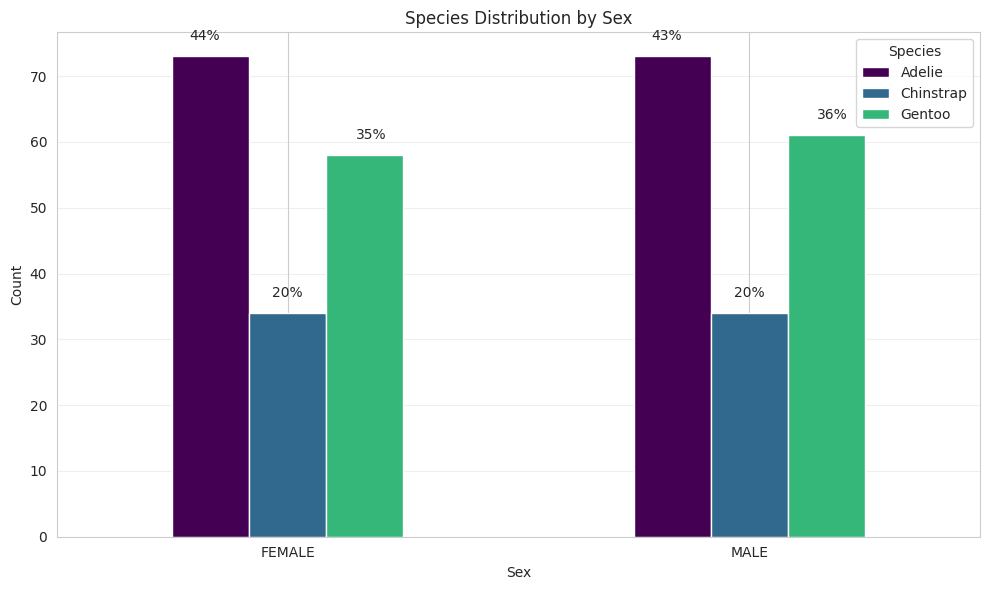

In [155]:
# Sex vs Species 
df_sex_clean = df[df['Sex'].isin(['MALE', 'FEMALE'])]

fig, ax = plt.subplots(figsize=(10, 6))

sex_species = pd.crosstab(df_sex_clean['Sex'], df_sex_clean['Species_Short'])
sex_species_pct = pd.crosstab(df_sex_clean['Sex'], df_sex_clean['Species_Short'], normalize='index') * 100

bars = sex_species.plot(kind='bar', ax=ax, color=['#440154', '#31688e', '#35b779'])
ax.set_title('Species Distribution by Sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.legend(title='Species', loc='best')
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', alpha=0.3)

for i, sex in enumerate(sex_species.index):
    for j, species in enumerate(sex_species.columns):
        count = sex_species.loc[sex, species]
        pct = sex_species_pct.loc[sex, species]
        x_pos = i + (j - 1) * 0.18
        ax.text(x_pos, count + 2, f'{int(pct)}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

sex distribution is pretty balanced across species - both male and female have roughly equal representation of all three species.

sex itself doesn't directly predict species (male penguins exist in all species obviously), BUT it interact with morphological features. males are often larger than females, so sex help the model by explaining some of the size variation within each species.

worth keeping after we clean that '.' error and augument missing values. might not be a primary predictor but could help as a secondary feature.

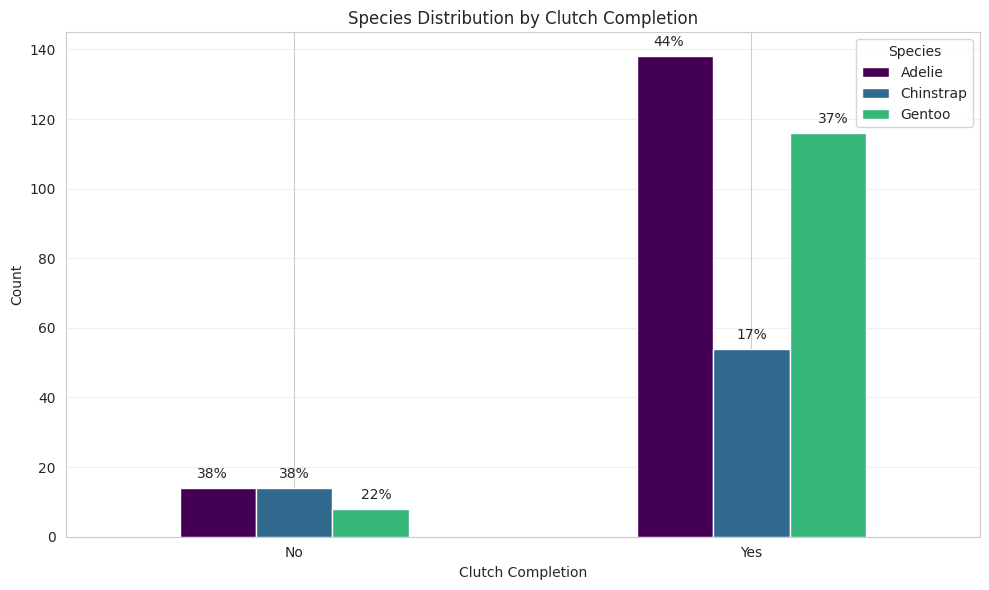

In [156]:
# Clutch Completion vs Species 
fig, ax = plt.subplots(figsize=(10, 6))

clutch_species = pd.crosstab(df['Clutch Completion'], df['Species_Short'])
clutch_species_pct = pd.crosstab(df['Clutch Completion'], df['Species_Short'], normalize='index') * 100

bars = clutch_species.plot(kind='bar', ax=ax, color=['#440154', '#31688e', '#35b779'])
ax.set_title('Species Distribution by Clutch Completion')
ax.set_xlabel('Clutch Completion')
ax.set_ylabel('Count')
ax.legend(title='Species', loc='best')
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', alpha=0.3)

for i, clutch in enumerate(clutch_species.index):
    for j, species in enumerate(clutch_species.columns):
        count = clutch_species.loc[clutch, species]
        pct = clutch_species_pct.loc[clutch, species]
        x_pos = i + (j - 1) * 0.18
        ax.text(x_pos, count + 2, f'{int(pct)}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

clutch completion is pretty useless:

- 308 "yes" vs only 36 "no" - massively imbalanced
- even thought it doesnt have the same distribution but due to low number of values in 'no' category we could say that this is due this, and basicaly this data coresponds to the number of species
- knowing clutch completion doesn't really tell you which species it is

this is a breeding behavior variable, not a morphological trait. apparently all three species have similar nesting success rates. might help marginally but probably won't move the needle much. could drop it or keep it - won't hurt either way.

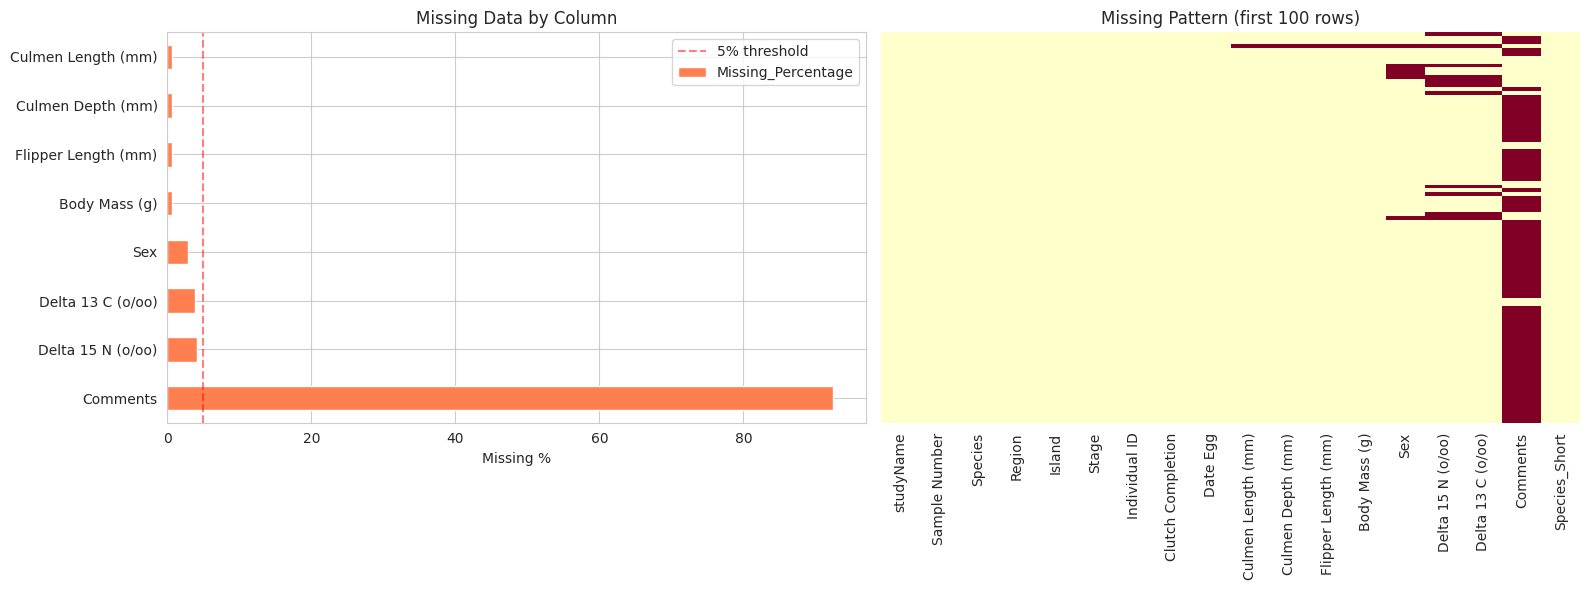

In [157]:
# Calculate missing stats
missing_stats = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of missing percentages
missing_stats.plot(y='Missing_Percentage', kind='barh', ax=axes[0], color='coral', legend=False)
axes[0].set_xlabel('Missing %')
axes[0].set_title('Missing Data by Column')
axes[0].axvline(x=5, color='red', linestyle='--', alpha=0.5, label='5% threshold')
axes[0].legend()

# Missing pattern heatmap
sample_size = 100
sns.heatmap(df.head(sample_size).isnull(), cbar=False, yticklabels=False, cmap='YlOrRd', ax=axes[1])
axes[1].set_title(f'Missing Pattern (first {sample_size} rows)')

plt.tight_layout()
plt.show()

Comments column has 92% missing - basically filled only when there's an issue. 

from the heatmap we can clearly see that almost all comments are in cases when we don't have some data, though some samples are commented even when they have all data - should verify if this data is there cause it could be an outlier. 

the comments could give us a great way to know why the data is missing and to use the best imputation strategy for that data based on the specific usecase.

In [158]:
df[df['Comments'].notna()]

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments,Species_Short
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.,Adelie
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.,Adelie
6,PAL0708,7,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N4A1,No,11/15/07,38.9,17.8,181.0,3625.0,FEMALE,9.18718,-25.21799,Nest never observed with full clutch.,Adelie
7,PAL0708,8,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N4A2,No,11/15/07,39.2,19.6,195.0,4675.0,MALE,9.46060,-24.89958,Nest never observed with full clutch.,Adelie
8,PAL0708,9,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N5A1,Yes,11/9/07,34.1,18.1,193.0,3475.0,NaN,NaN,NaN,No blood sample obtained.,Adelie
9,PAL0708,10,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N5A2,Yes,11/9/07,42.0,20.2,190.0,4250.0,NaN,9.13362,-25.09368,No blood sample obtained for sexing.,Adelie
10,PAL0708,11,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N6A1,Yes,11/9/07,37.8,17.1,186.0,3300.0,NaN,8.63243,-25.21315,No blood sample obtained for sexing.,Adelie
11,PAL0708,12,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N6A2,Yes,11/9/07,37.8,17.3,180.0,3700.0,NaN,NaN,NaN,No blood sample obtained.,Adelie
12,PAL0708,13,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N7A1,Yes,11/15/07,41.1,17.6,182.0,3200.0,FEMALE,NaN,NaN,Not enough blood for isotopes.,Adelie
13,PAL0708,14,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N7A2,Yes,11/15/07,38.6,21.2,191.0,3800.0,MALE,NaN,NaN,Not enough blood for isotopes.,Adelie


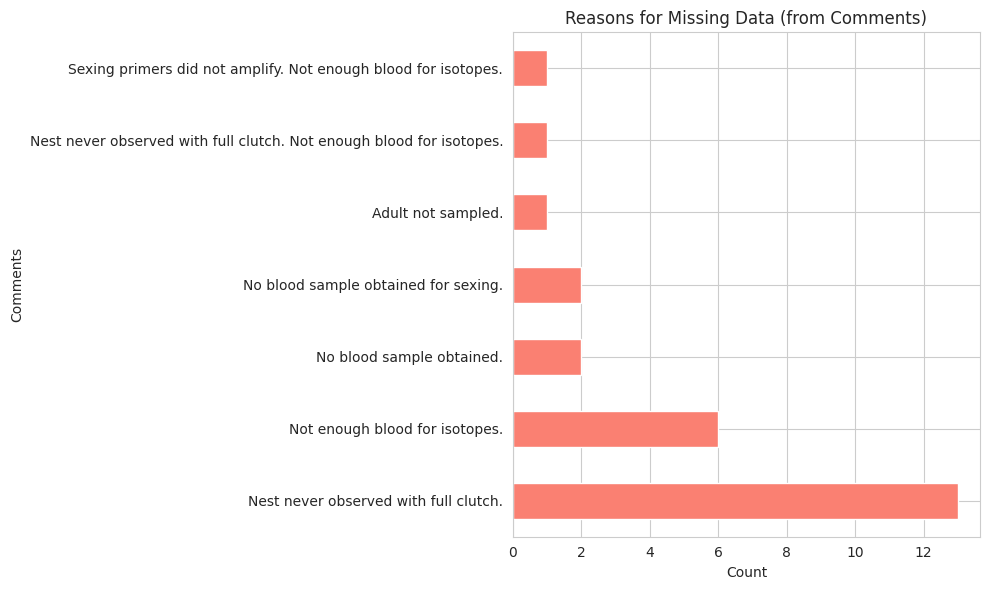

In [159]:
# Analyze comments
commented_rows = df[df['Comments'].notna()]
comment_counts = commented_rows['Comments'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
comment_counts.plot(kind='barh', ax=ax, color='salmon')
ax.set_xlabel('Count')
ax.set_title('Reasons for Missing Data (from Comments)')
plt.tight_layout()
plt.show()

ok so from the comments we can see the actual reasons:
- "nest never observed with full clutch" - most common, sampling issue, basically explained why they putted no at clutch completion even thought they are not sure 
- "not enough blood for isotopes" - explains why isotope values are missing, this info explains Delta 15 and Delta 13 value missing
- "no blood sample obtained" - similar, no sample = no measurements, the thing with delta and sex missing 
- "adult not sampled" - explains missing morphological measurements, all morphological data missing 
- sexing issues - explains missing sex values, basically werent enought blood for test completion

this is NOT random missingness (MCAR). it's either MAR (missing at random) or MNAR (missing not at random) because:
- isotope values are missing BECAUSE no blood sample was taken
- sex is missing BECAUSE amplification failed or no sample
- measurements are missing BECAUSE the adult wasn't sampled

so simple mean/median imputation would be statistically wrong here. we need methods that account for relationships between features - MICE (iterative imputer) for numerical data and KNN imputer for categorical (sex) to use info from similar samples.

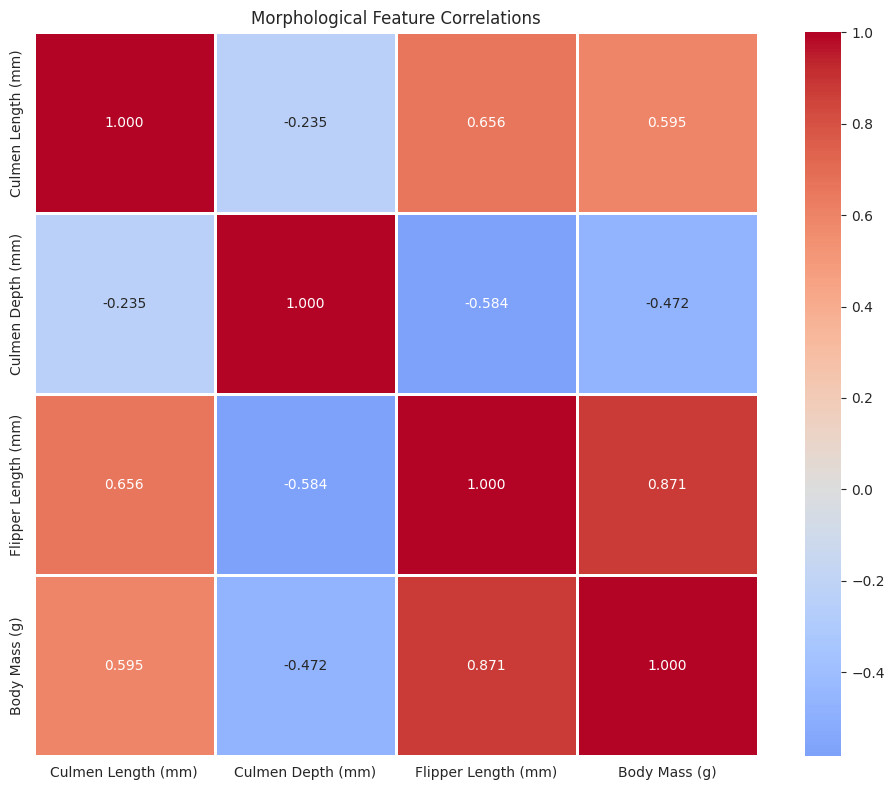

In [160]:
# Correlation matrix for morphological features
correlation_matrix = df[morph_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Morphological Feature Correlations')
plt.tight_layout()
plt.show()

from the correlation heatmap:
- flipper length and body mass have strong positive correlation (0.87) - makes sense, bigger penguins have longer flippers
- flipper length and culmen length also correlated (0.66)
- culmen depth is negatively correlated with culmen length (-0.24) and flipper length (-0.58) - interesting, deeper beaks tend to be shorter

high multicollinearity between flipper/body mass means they carry redundant information. ZCA whitening or feature selection (phik selector) could help decorrelate these and improve model stability.

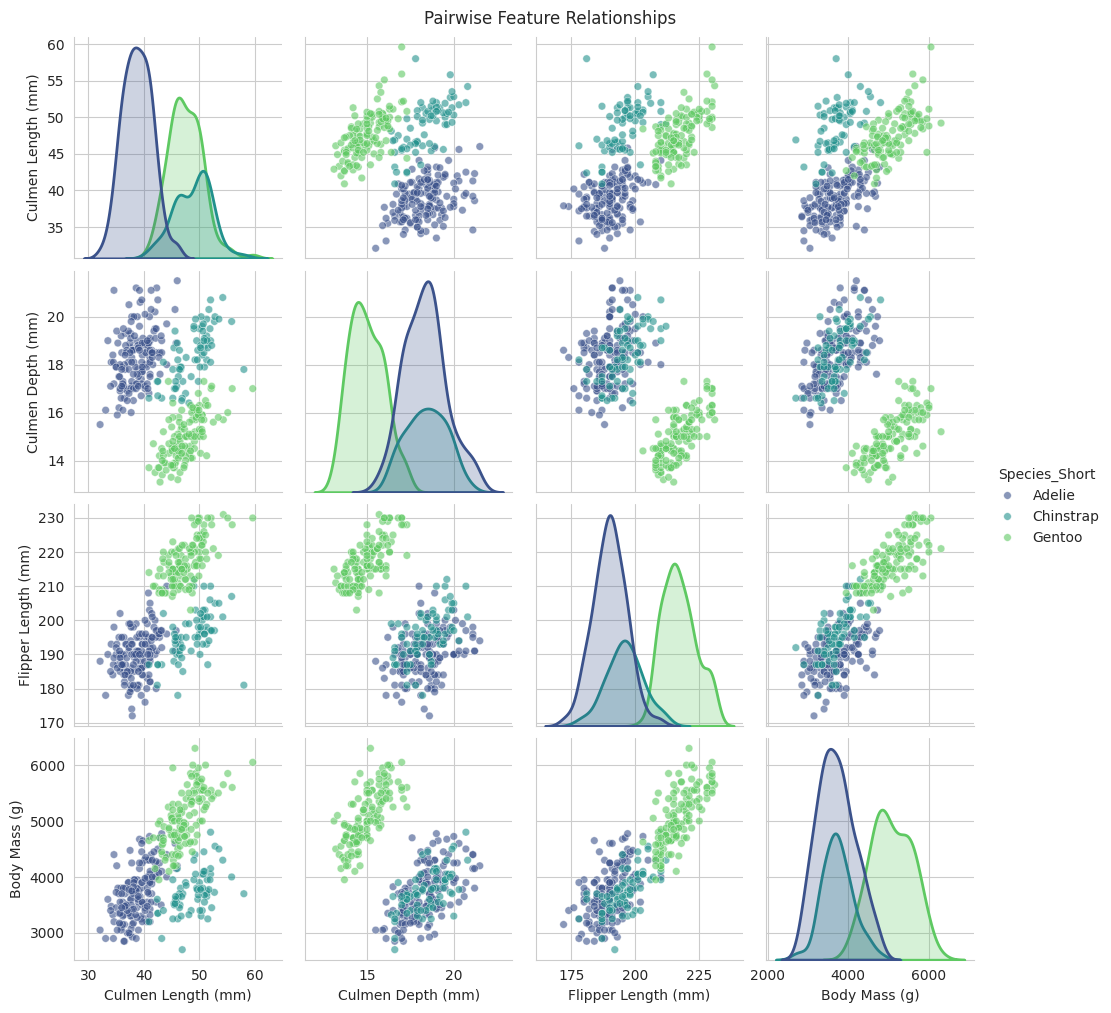

In [161]:
pairplot = sns.pairplot(df, vars=morph_features, hue='Species_Short', palette='viridis', 
                        diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30}, diag_kws={'linewidth': 2})
pairplot.fig.suptitle('Pairwise Feature Relationships', y=1.01)
plt.show()

**Pairwise Feature Interactions**

Scatter plots for all feature pairs - see where species separate cleanly vs where they overlap.
we can clearly see that culmen lenght paired with rest of the features creates great separation between classes

bottom line: this is gonna be a tough classification problem for adelie vs chinstrap. gentoo is easy.

we will use the best examples from here to create best decision boundaries below

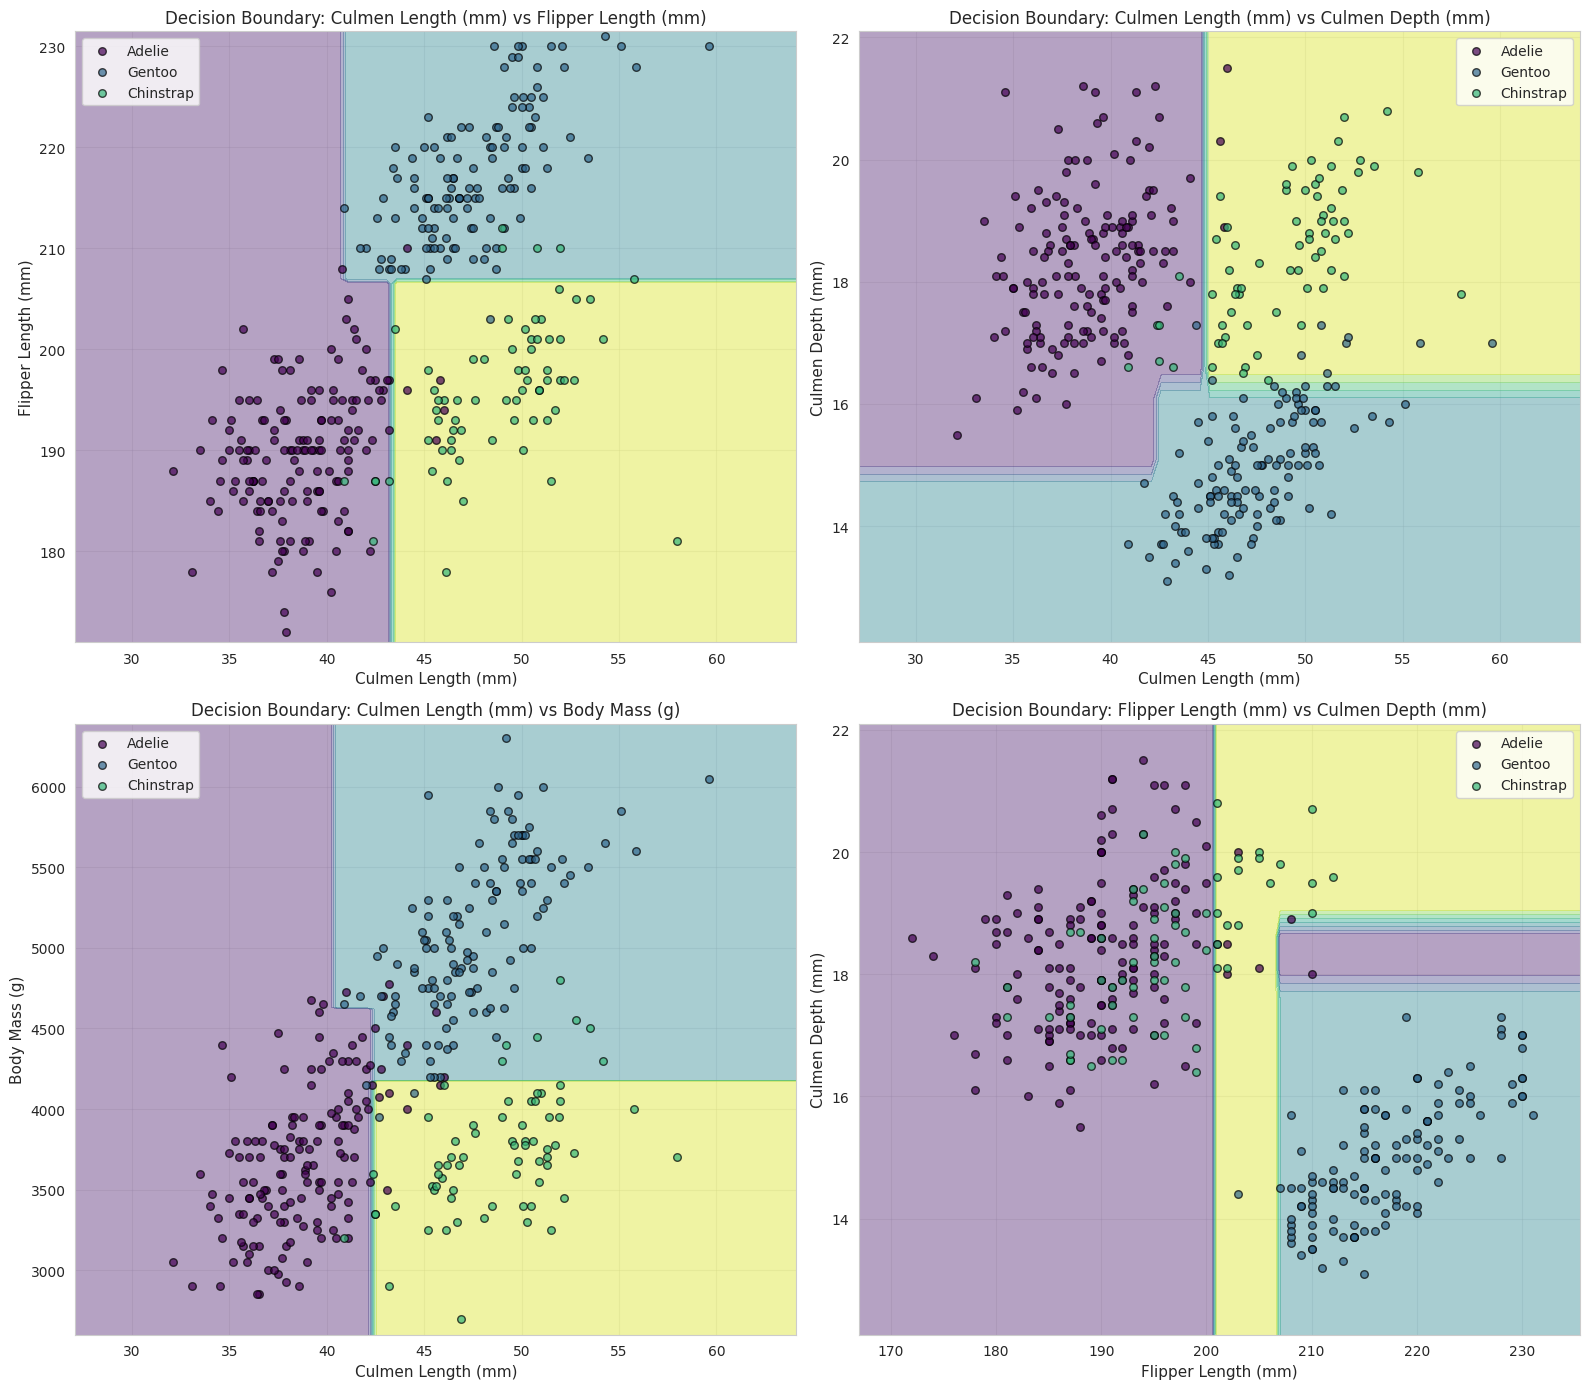

In [162]:
from sklearn.tree import DecisionTreeClassifier

df_clean = df[morph_features + ['Species_Short']].dropna()
species_map = {'Adelie': 0, 'Gentoo': 1, 'Chinstrap': 2}
y_numeric = df_clean['Species_Short'].map(species_map)

# Select interesting feature pairs
feature_pairs = [
    ['Culmen Length (mm)', 'Flipper Length (mm)'],
    ['Culmen Length (mm)', 'Culmen Depth (mm)'],
    ['Culmen Length (mm)', 'Body Mass (g)'],
    ['Flipper Length (mm)', 'Culmen Depth (mm)']
]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

plot_colors = ['#440154', '#31688e', '#35b779']  # viridis colors
plot_step = 0.5

for idx, pair in enumerate(feature_pairs):
    # Get the two features
    X_pair = df_clean[pair].values
    y = y_numeric.values
    
    # Train decision tree
    clf = DecisionTreeClassifier(max_depth=3, random_state=42).fit(X_pair, y)
    
    # Create mesh
    x_min, x_max = X_pair[:, 0].min() - 5, X_pair[:, 0].max() + 5
    y_min, y_max = X_pair[:, 1].min() - 100 if 'Body Mass' in pair[1] else X_pair[:, 1].min() - 1, \
                   X_pair[:, 1].max() + 100 if 'Body Mass' in pair[1] else X_pair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step if 'Body Mass' not in pair[1] else plot_step*20))
    
    # Predict on mesh
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    axes[idx].contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    
    # Plot training points
    for i, color in enumerate(plot_colors):
        idx_class = np.where(y == i)
        axes[idx].scatter(X_pair[idx_class, 0], X_pair[idx_class, 1], 
                         c=color, label=list(species_map.keys())[i],
                         edgecolor='black', s=30, alpha=0.7)
    
    axes[idx].set_xlabel(pair[0], fontsize=11)
    axes[idx].set_ylabel(pair[1], fontsize=11)
    axes[idx].set_title(f'Decision Boundary: {pair[0]} vs {pair[1]}')
    axes[idx].legend(loc='best')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

decision boundaries confirm what we saw in the distributions:


**culmen length vs culmen depth or flipper length or body mass** - create a clean separation.

**flipper length vs culmen depth** - gentoo well separated, but adelie/chinstrap share decision regions.

for tree-based models, culmen length + culmen depth or flipper length or body massmass will be high importance features.

## Summary

**dataset overview:**
- 344 unique penguins (all 344 rows are different birds)
- individual IDs were reused across study years for different penguins
- 3 species: adelie (152), gentoo (124), chinstrap (68) - imbalanced 2.2:1 ratio
- 4 key morphological measurements + isotope data + categorical features
- missing data in 8 columns

**morphological features:**
- flipper length: gentoo ~215mm, adelie ~190mm, chinstrap ~195mm
- body mass: gentoo ~5000g vs adelie/chinstrap ~3700-3800g
- culmen depth: adelie/chinstrap ~18.5mm, gentoo ~15mm
- culmen length: more overlap but still varies between species

gentoo is clearly distinct. adelie and chinstrap heavily overlap. model will need feature combinations.

**island - super strong predictor:**
- torgersen: 100% adelie
- biscoe: adelie + gentoo mix, NO chinstrap
- dream: adelie + chinstrap mix, NO gentoo

geographic separation acts as hard constraint.

**sex:** balanced across species, interacts with morphological features (males larger). worth keeping after cleaning '.' error.

**missing data:** NOT random (MAR/MNAR). need MICE for numerical, KNN for categorical.

**correlation:** flipper length and body mass strongly correlated (0.87) - redundant info.

**features to drop:**
- region, stage (constant)
- studyName, date egg, sample number (temporal/arbitrary)
- comments, clutch completion (not useful)
- individual ID (just identifier, reused across studies)

**features to keep:**
- morphological: culmen length, culmen depth, flipper length, body mass
- island (very strong predictor)
- sex
- isotope data

**preprocessing plan:**
- regular train/test split (no GroupShuffleSplit needed - all 344 penguins are unique)
- fix sex: replace '.' with NaN
- MICE for numerical missing values
- KNN imputer for sex
- handle class imbalance with SMOTEENN OR 

**expected performance:**
- gentoo: near perfect (clearly distinct + island helps)
- adelie vs chinstrap: harder (mainly on dream island)
- overall: 90-95% accuracy expected